*   Microproyecto 4
*   Equipo 4
* Arias Santiago
* Funez Camilo
* Mosquera Nicolas

#4) (40%) a. Realice un ejemplo sencillo en Python usando las librerías que considere  en donde se ilustre la mayoría de los conceptos presentados anteriormente y cuyo objetivo sea la clasificación de objetos (AVES)

Para realizar ésta actividad, se tuvo en cuenta el data set de 285 especies de aves, pero por motivos de simplicidad, aquí solo se trabaja con 10 especies. Dicho data set ya viene con una organización predeterminada.

Conjunto de datos de 285 especies de aves: 40930 imágenes de entrenamiento, 1425 imágenes de prueba (5 imágenes por especie) y 1425 imágenes de validación (5 imágenes por especie.
Todas las imágenes son imágenes de 224 X 224 X 3 colores en formato jpg. El conjunto de datos incluye un conjunto de trenes, un conjunto de pruebas y un conjunto de validación. Cada conjunto contiene 285 subdirectorios, uno para cada especie de ave.

El conjunto de datos también incluye un archivo Bird Species.csv. Este archivo csv contiene tres columnas. La columna de rutas de archivo contiene la ruta de archivo a un archivo de imagen, la columna de etiquetas contiene el nombre de clase asociado con el archivo de imagen y la última columna es el grupo al cual pertenece la imagen (train, validation o test set).

El data set completo puede ser visitado en: https://www.kaggle.com/gpiosenka/100-bird-species

**CÓDIGO**

El dataset se guardó en Google Drive, por consiguiente, es necesario acceder a él para trabajar.

In [ ]:
#Se importa el almacenamiento Google Drive, ésto puede ser visible desde el menú de la izquierda
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Se importan las librerías necesarias.

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import os
from skimage.io import imread
%matplotlib inline

Se carga el archivo csv que contiene los labels de cada imagen

In [ ]:
all_data = pd.read_csv('/content/drive/MyDrive/Inteligencia Artificial (IA)/Microproyecto4/birds_rev2/birds.csv')    # reading the csv file
all_data.head()      # printing first five rows of the file

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train


Se seleccionan 1524 imágenes para entrenamiento, corresponden a las primeras 10 especies de aves

In [ ]:
y_train=(((all_data[all_data["data set"]=="train"]).head(1524))['labels'])
y_train.shape

(1524,)

Las especies de aves con las cuales se trabajará el modelo son:

In [ ]:
pd.unique(y_train)

array(['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT'], dtype=object)

Se extraen los labels de las 50 imágenes de validación

In [ ]:
y_valid=((all_data[all_data["data set"]=="valid"])['labels']).head(50)
y_valid.shape

(50,)

Se extraen los labels de las 50 imágenes que pueden ser usadas para pronóstico

In [ ]:
y_pred=((all_data[all_data["data set"]=="test"])['labels']).head(50)
y_pred.shape

(50,)

# Carga de imágenes y preprocesamiento

Se cargan las imágenes y se convierten a np.arrays (ésto facilita las operaciones)

Set de entrenamiento

In [ ]:
imgT_path='/content/drive/MyDrive/Inteligencia Artificial (IA)/Microproyecto4/birds_rev2/train'
x_train=[]
for filename in sorted(os.listdir(imgT_path))[:10] :
  new_path=imgT_path+'/'+filename
  for img in sorted(os.listdir(new_path)):
    bird=imread(new_path+'/'+img)
    bird = image.img_to_array(bird)
    bird = bird/255
    x_train.append(bird)
x_train=np.array(x_train)

Set de Validación

In [ ]:
imgV_path='/content/drive/MyDrive/Inteligencia Artificial (IA)/Microproyecto4/birds_rev2/valid'
x_valid=[]
for filename in sorted(os.listdir(imgV_path))[:10] :
  new_path=imgV_path+'/'+filename
  for img in sorted(os.listdir(new_path)):
    bird=imread(new_path+'/'+img)
    bird = image.img_to_array(bird)
    bird = bird/255
    x_valid.append(bird)
x_valid=np.array(x_valid)

Set de pronóstico

In [ ]:
imgP_path='/content/drive/MyDrive/Inteligencia Artificial (IA)/Microproyecto4/birds_rev2/test'
x_pred=[]
for filename in sorted(os.listdir(imgP_path))[:10] :
  new_path=imgP_path+'/'+filename
  for img in sorted(os.listdir(new_path)):
    bird=imread(new_path+'/'+img)
    bird = image.img_to_array(bird)
    bird = bird/255
    x_pred.append(bird)
x_pred=np.array(x_pred)

A continuación se observa la estructura (esperada) de cada dataset

In [ ]:
x_train.shape

(1524, 224, 224, 3)

In [ ]:
x_valid.shape

(50, 224, 224, 3)

In [ ]:
x_pred.shape

(50, 224, 224, 3)

reshape de los features objetivos para que puedan ser usados por el modelo

In [ ]:
y_train=pd.get_dummies(y_train).values
y_valid=pd.get_dummies(y_valid).values

(1524, 10)

# Creación del modelo

A continuación se crea un modelo secuencial (por capas), y los parámetros usados fueron probados anteriormente buscando una optimización del modelo.
Se probaron kernels 2x2, 3x3 y 5x5, funciones de activación relu, tanh, sigmoide y softmax, dropouts de 0.1, 0.2, 0.5 y 0.8, además de tamaños de filtros ascendentes como descendentes.
Lo que más influyó en la optimización del modelo, fue dropout que para éste caso uno pequeño funciona mejor, y el tamaño del filtro.

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="tanh", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="tanh"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5,5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

Se encontró en la documentación consultada que para problemas de clasificación multiclase se recomienda como última función de activación Softmax.

La última capa densa del módelo tiene 10 unidades de dimensionalidad de salida ya que corresponde al número de especies.

Se imprime un resumen del modelo

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 49, 49, 64)       

Se observa que son 1.092.454 parámetros de entrenamiento que deben ser ajustados.

# Compilación y Ajuste

Como optimizador se opta por usar Adam, exactitud como métrica y como función de error categorical_crossentropy ya que es una buena opción para problemas de clasificacición multiclases.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Se entrena el modelo y se guardan sus registros de entrenamiento usando los datasets de entrenamiento y validación predeterminados, ya que al final, después de realizar varias pruebas (test_split=0.1 y test_split=0.2) se concluyó que éste era la mejor configuración del modelo.

In [ ]:
history=model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), batch_size=64)

Epoch 1/50
24/24 [==============================] - 5s 156ms/step - loss: 2.3707 - accuracy: 0.1115 - val_loss: 2.1803 - val_accuracy: 0.2400
Epoch 2/50
24/24 [==============================] - 3s 145ms/step - loss: 2.1682 - accuracy: 0.2014 - val_loss: 2.0958 - val_accuracy: 0.2200
Epoch 3/50
24/24 [==============================] - 3s 146ms/step - loss: 2.1317 - accuracy: 0.2165 - val_loss: 1.9728 - val_accuracy: 0.3200
Epoch 4/50
24/24 [==============================] - 3s 145ms/step - loss: 1.9100 - accuracy: 0.3110 - val_loss: 1.6908 - val_accuracy: 0.4000
Epoch 5/50
24/24 [==============================] - 3s 145ms/step - loss: 1.7901 - accuracy: 0.3563 - val_loss: 1.4868 - val_accuracy: 0.4200
Epoch 6/50
24/24 [==============================] - 3s 145ms/step - loss: 1.6945 - accuracy: 0.3950 - val_loss: 1.6327 - val_accuracy: 0.4200
Epoch 7/50
24/24 [==============================] - 3s 145ms/step - loss: 1.6013 - accuracy: 0.4462 - val_loss: 1.5279 - val_accuracy: 0.4400
Epoch 

# b. Al finalizar la ejecución del código deben presentar la matriz de confusión obtenida, el cálculo del valor de las métricas de desempeño Exactitud (Accuracy), Precisión, Sensibilidad (Recall), f1-Score y analizar qué tan bueno es el clasificador de imágenes obtenido.

# Gráficas

Exactitud a través de cada epoch

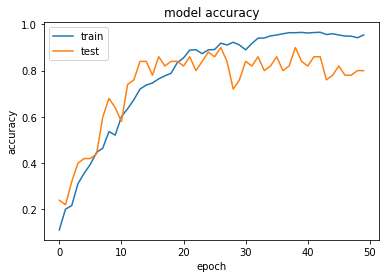

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Error en cada epoch

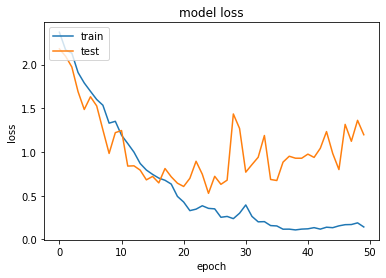

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Matriz de confusión en entrenamiento

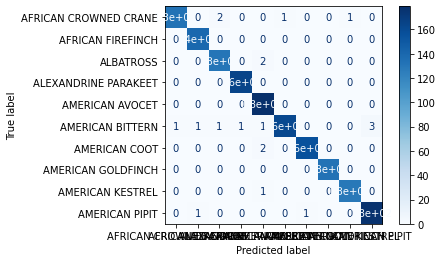

In [ ]:
pred=model.predict(x_train)
matrix = confusion_matrix(y_train.argmax(axis=1), pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print('Classification Report For Trainning')
target_names=['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT']
print(classification_report(y_train.argmax(axis=1), pred.argmax(axis=1), target_names=target_names))

Classification Report For Trainning
                       precision    recall  f1-score   support

AFRICAN CROWNED CRANE       0.99      0.97      0.98       137
    AFRICAN FIREFINCH       0.99      1.00      0.99       140
            ALBATROSS       0.98      0.98      0.98       133
 ALEXANDRINE PARAKEET       0.99      1.00      1.00       165
      AMERICAN AVOCET       0.97      1.00      0.98       179
     AMERICAN BITTERN       0.99      0.95      0.97       170
        AMERICAN COOT       0.99      0.99      0.99       158
   AMERICAN GOLDFINCH       1.00      1.00      1.00       133
     AMERICAN KESTREL       0.99      0.99      0.99       130
       AMERICAN PIPIT       0.98      0.99      0.99       179

             accuracy                           0.99      1524
            macro avg       0.99      0.99      0.99      1524
         weighted avg       0.99      0.99      0.99      1524



Matriz de confusión en validación

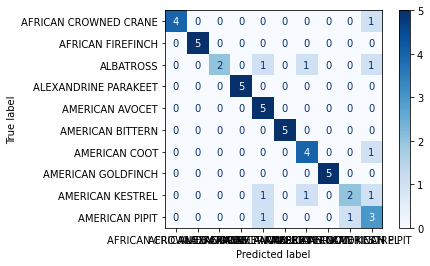

In [ ]:
pred=model.predict(x_valid)
matrix = confusion_matrix(y_valid.argmax(axis=1), pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print('Classification Report For Validation')
target_names=['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT']
print(classification_report(y_valid.argmax(axis=1), pred.argmax(axis=1), target_names=target_names))

Classification Report For Validation
                       precision    recall  f1-score   support

AFRICAN CROWNED CRANE       1.00      0.80      0.89         5
    AFRICAN FIREFINCH       1.00      1.00      1.00         5
            ALBATROSS       1.00      0.40      0.57         5
 ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
      AMERICAN AVOCET       0.62      1.00      0.77         5
     AMERICAN BITTERN       1.00      1.00      1.00         5
        AMERICAN COOT       0.67      0.80      0.73         5
   AMERICAN GOLDFINCH       1.00      1.00      1.00         5
     AMERICAN KESTREL       0.67      0.40      0.50         5
       AMERICAN PIPIT       0.43      0.60      0.50         5

             accuracy                           0.80        50
            macro avg       0.84      0.80      0.80        50
         weighted avg       0.84      0.80      0.80        50



# Predicción

Real :- [[0 0 0 0 0 0 0 0 0 1]]
Predicted :-  AMERICAN PIPIT


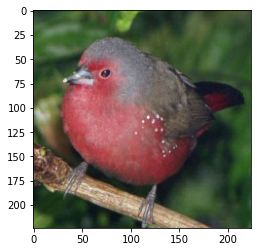

In [ ]:
# Testing predictions and the actual label
checkImage = x_pred[49:50]
checklabel = y_pred[49:50]

predict = model.predict(checkImage)
output={0:'AFRICAN CROWNED CRANE',1:'AFRICAN FIREFINCH',2:'ALBATROSS',3:'ALEXANDRINE PARAKEET',4:'AMERICAN AVOCET',5:'AMERICAN BITTERN',6:'AMERICAN COOT',
        7:'AMERICAN GOLDFINCH',8:'AMERICAN KESTREL',9:'AMERICAN PIPIT'}
print("Real :-",checklabel)
plt.imshow(x_pred[5])
print("Predicted :- ",output[np.argmax(predict)])

In [ ]:
y_pred=pd.get_dummies(y_pred).values

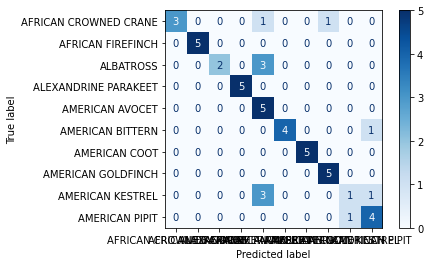

In [ ]:
pred=model.predict(x_pred)
matrix = confusion_matrix(y_pred.argmax(axis=1), pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print('Classification Report For Prediction')
target_names=['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT']
print(classification_report(y_valid.argmax(axis=1), pred.argmax(axis=1), target_names=target_names))

Classification Report For Prediction
                       precision    recall  f1-score   support

AFRICAN CROWNED CRANE       1.00      0.60      0.75         5
    AFRICAN FIREFINCH       1.00      1.00      1.00         5
            ALBATROSS       1.00      0.40      0.57         5
 ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
      AMERICAN AVOCET       0.42      1.00      0.59         5
     AMERICAN BITTERN       1.00      0.80      0.89         5
        AMERICAN COOT       1.00      1.00      1.00         5
   AMERICAN GOLDFINCH       0.83      1.00      0.91         5
     AMERICAN KESTREL       0.50      0.20      0.29         5
       AMERICAN PIPIT       0.67      0.80      0.73         5

             accuracy                           0.78        50
            macro avg       0.84      0.78      0.77        50
         weighted avg       0.84      0.78      0.77        50



#Conclusiones




*  la importancia que tiene disponer de un
conjunto de imágenes de entrenamiento suficientemente amplio y
representativo del problema para obtener resultados satisfactorios con una
red neuronal convolucional.

* las librerías NumPy,OpenCV y especialmente TensorFlow, facilitan enormemente el trabajo a lahora de diseñar sistemas de clasificación de imágenes basados en redes neuronales. Operaciones complejas como las que llevan a cabo los
algoritmos de tratamiento de imágenes

* La optimización del modelo en términos de capas, dropouts, división de datos para validación y entrenamiento, funciones de activación, etc. se realiza a base de prueba y error.

* La función de activación recomendada en las últimas capas para problemas de clasificación multiclases es Softmax.

* El modelo logró una exactitud de 98% y 99% en f1-score y recall en entrenamiento. 84% de exactitud y 80% de f1-score y recall en validación, y en pronóstico una exactitud de 84%, 78% en recall y 77% en f1-score. Lo que significa que el modelo es aceptable.



# Referencias



*   Build your First Multi-Label Image Classification Model in Python : https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/

*   MultiClass Image Classification using keras: https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras


* 285 Bird Species - Classification: https://www.kaggle.com/gpiosenka/100-bird-species

* Confusion Matrix for Your Multi-Class Machine Learning Model: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

